# TP4 Faverjon

## Franke and Westerhoffe

In [192]:
import numpy as np
from matplotlib import pyplot as plt
import math as m
import sympy as sp
import powerlaw
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
from scipy.optimize import minimize

1.

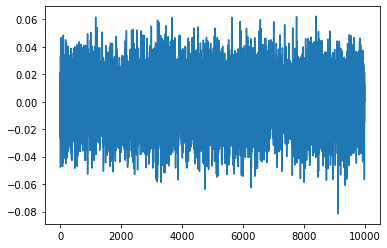

In [190]:
def modele(sigmaf, sigmac, phi, chi, mu, nu, a0, ax, ad, duree): 
    epsilonf = np.random.normal(size=duree, scale = sigmaf)
    epsilonc = np.random.normal(size=duree, scale = sigmac)
    xt=0
    r=[0]
    
    # we consider p* = 0
    p= [0.2,0.2] 
   
    for t in range(1,duree): 
        pt =sum(r)
        p.append(pt)
        df = -phi*p[-1]+ epsilonf[t]
        dc = chi*(p[-1]-p[-2]) + epsilonc[t]
        dt = ((1+xt)/2)*df + ((1-xt)/2)*dc
        r.append(mu*dt)
        st= a0+ax*xt+ad*p[-1]**2
        xtt= xt + nu*((1-xt)*m.exp(st)-(1+xt)*m.exp(-st))
        xt = min(abs(xtt),1)*np.sign(xtt)

    return r


a = modele(0.79,1.91,1.8,2.1,0.01,2.57,-3.5,1.35, 11.4,10000)
#a  modele(0.79,1.91,oooo,oooo,0.01,2.57,ooooo,1.35, 11.4,10000)


plt.plot(a)





    









2. Plot P(abs(r)>R)


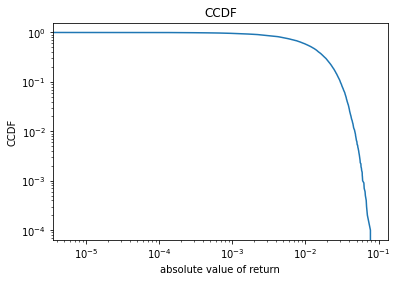

In [168]:
a = np.abs(a)
proba = ECDF(a)
plt.plot(proba.x, 1-proba.y)
plt.xscale('log')
plt.yscale('log')
plt.title("CCDF")
plt.xlabel("absolute value of return")
plt.ylabel("CCDF")
plt.show()

3) Heavy-tail calculation

In [191]:
a= np.abs(a)
data2 = powerlaw.Fit(a)
alpha = data2.power_law.alpha
#xmin = data2.power_law.xmin
print(alpha)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


10.146749531884414


For the market, alpha = 4, so it shows that our model is quite good in simulating the market.

4) For different set of parameters, we obtain around the same value of c, so it means that c doesn't uniquely determine the parameters set

## Calibrate the model

1. Plot the ECDF

Calculating best minimal value for power law fit
/Users/paulfaverjon/miniforge3/envs/finance/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


9.192649641974148 0.062049035076951


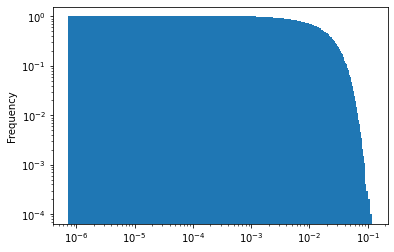

In [103]:
df=pd.read_csv (r'f-w.output.csv')
df['value'] = df['value'].abs()
ax = df['value'].plot.hist(bins = 100, cumulative = -1, density = 1, logx =True, logy= True)
data = df['value'].to_numpy() # I took the liberty of calculating P(abs(r)>R) instead of just P(r>R)
data3 = powerlaw.Fit(data)
alpha1 = data3.power_law.alpha
xmin = data3.power_law.xmin

print(alpha1, xmin)


The exponent found on the file value is quite much higher than the one found with our model, it therefore means that we need to changes parameters of our model.

2. Minimization fo the cost function K

In [166]:
# This is almost the same model, but a0 and ax have been squared in the formulas so that skipit learn can be used.
def modele2(var): 
    phi,chi,a0,ax,ad = var[0],var[1],var[2],var[3], var[4]
    sigmaf = 0.79
    sigmac = 1.91
    mu = 0.18
    nu = 2.35
    duree = 10000
    epsilonf = np.random.normal(size=duree, scale = sigmaf)
    epsilonc = np.random.normal(size=duree, scale = sigmac)
    xt=0
    r=[0]
    
    # we consider p* = 0
    p= [0.2,0.2] 
   
    for t in range(1,duree): 
        pt =sum(r)
        p.append(pt)
        df = -phi*p[-1]+ epsilonf[t]
        dc = chi*(p[-1]-p[-2]) + epsilonc[t]
        dt = ((1+xt)/2)*df + ((1-xt)/2)*dc
        r.append(mu*dt)
        st= a0+(ax**2)*xt+(ad**2)*p[-1]**2
        xtt= xt + nu*((1-xt)*m.exp(st)-(1+xt)*m.exp(-st))
        xt = min(abs(xtt),1)*np.sign(xtt)


    r = np.abs(r)
    r1 = powerlaw.Fit(a)
    alpha = r1.power_law.alpha
    global alpha1
    s= (alpha-alpha1)**2

    
    return s


b = scipy.optimize.minimize(modele2,x0 =np.array([0.18,2.35,-0.15, 1.35,11.4]), bounds =[(-10,10),(-10,10),(-10,10),(-10,10),(-15,15)] )

print(b)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


      fun: 1.889302969504415
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 0.18,  2.35, -0.15,  1.35, 11.4 ])


This method however is not very efficient as it computes very slowly, and as the behaviour of the function is very complex, it doesn't work properly. Also, the result of the function fluctuates a lot, as we will show in the next part

## Minimizing K by hand

##### We now take as a target value 9.1926

I have found by hand Phi = 1.8, Chi = 2.1 and a0 = -3.5

In [194]:
res = []
for i in range(20) : 
    a = modele(0.79,1.91,1.8,2.1,0.01,2.57,-3.5,1.35, 11.4,10000)
    a= np.abs(a)
    data2 = powerlaw.Fit(a)
    alpha = data2.power_law.alpha
    res.append(alpha)

print(res)
print ("variance is",np.std(res))
print ("average is", np.average(res))

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/paulfaverjon/miniforge3/envs/finance/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal

[10.153781359737444, 7.724112520784648, 8.715996162551297, 8.51316372479759, 7.0353076085089326, 5.636513096987049, 10.086540953078854, 8.214931381651947, 9.362498303530339, 10.704142459358003, 7.10666682236328, 13.868826703107063, 8.210094614602376, 5.17896943331471, 6.2809967202742705, 6.625843324536787, 5.924599726577935, 6.437363414352371, 5.675731353385895, 8.20489154956202]
4.292529738523258
7.98304856165314


### We realize that the standard deviation is very important and that the average is not what we wanted it to be. it goes to show that it is very difficult to optimize the parameters... When tested by hand before, those parameters gave an average on 9..., and now of 7.9.